#Multiple Linear Regression model for the prediction of demand for shared Bikes

Problem Statement

A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

The company wants to know:

Which variables are significant in predicting the demand for shared bikes.
How well those variables describe the bike demands

Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors

Steps:
    1. Reading, Understanding and Visualising the data
    2. Preparing the data for modelling(train-test split, rescaling etc.)
    3. Training the model
    4. Residual analysis
    5. Predictions and evaluation on the test set
    

# Step 1: Reading, Understanding and Visualising the data

In [1]:
#importing the numpy and pandas and read the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# read the dataset
bike= pd.read_csv('day(1).csv')
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [4]:
 #percentage of missing values in each column

round(100*(bike.isnull().sum()/len(bike)), 2).sort_values(ascending=False)


cnt           0.0
registered    0.0
casual        0.0
windspeed     0.0
hum           0.0
atemp         0.0
temp          0.0
weathersit    0.0
workingday    0.0
weekday       0.0
holiday       0.0
mnth          0.0
yr            0.0
season        0.0
dteday        0.0
instant       0.0
dtype: float64

Data preparation

- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

dropping instant and dtedate
1. instant:  since it is an index column and not required for analysis 
2. dtedate: we already have a column with month and year, so date is not required for analysis
3. casual and registered as casual+registered - cnt, hence dropping casual and registered and not using for model building

In [5]:
bike=bike.drop(["dteday", "instant","casual","registered"],axis=1) 

Converting categorical columns

In [6]:
bike.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [7]:
#season (1:spring, 2:summer, 3:fall, 4:winter
def seasn(x):
    if x==1:
        return "spring"
    elif x==2:
        return "summer"
    elif x==3:
        return "fall"
    else:
        return "winter"
bike["season"]=bike["season"].apply(seasn)

In [8]:
bike.mnth.value_counts()

12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     56
Name: mnth, dtype: int64

In [9]:
def object_map(x):
    return x.map({
        1:'Jan',
        2:'Feb',
        3:'Mar',
        4:'Apr',
        5:'May',
        6:'Jun',
        7:'Jul',
        8:'Aug',
        9:'Sep',
        10:'Oct',
        11:'Nov',
        12:'Dec'
    })

bike[['mnth']] = bike[['mnth']].apply(object_map)

In [10]:
bike.weekday.value_counts()

2    105
1    105
6    104
5    104
4    104
3    104
0    104
Name: weekday, dtype: int64

In [11]:
def weekdy(x):
    return x.map({
        0:'Sun',
        1:'Mon',
        2:'Tue',
        3:'Wed',
        4:'Thr',
        5:'Fri',
        6:'Sat',
    })

bike[['weekday']] = bike[['weekday']].apply(weekdy)

In [12]:
bike.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [13]:
# weathersit : 1: Clear,2: Mist 3: Snow&Rain,4: HeavyRain
def weather(x):
    if x==1:
        return "Clear"
    elif x==2:
        return "Mist"
    elif x==3:
        return "Snow&Rain"
    else:
        return ""
bike["weathersit"]=bike["weathersit"].apply(weather)



In [14]:
bike.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.690411,20.319259,23.726322,62.765175,12.763620,4508.006849
std,0.500343,0.167266,0.462641,7.506729,8.150308,14.237589,5.195841,1936.011647
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


# EDA on DF_train dataset

In [15]:
# Visuilasation on numerical variables

In [16]:
numerical=["cnt","temp","atemp", "hum","windspeed"]

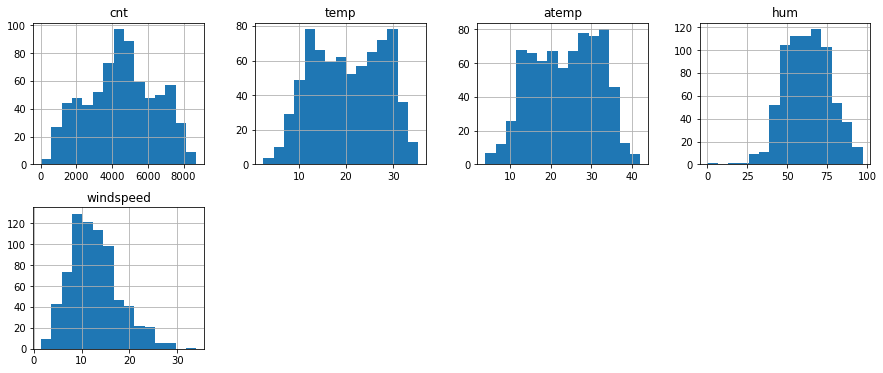

In [17]:
bike[numerical].hist(bins=15, figsize=(15, 6), layout=(2, 4));

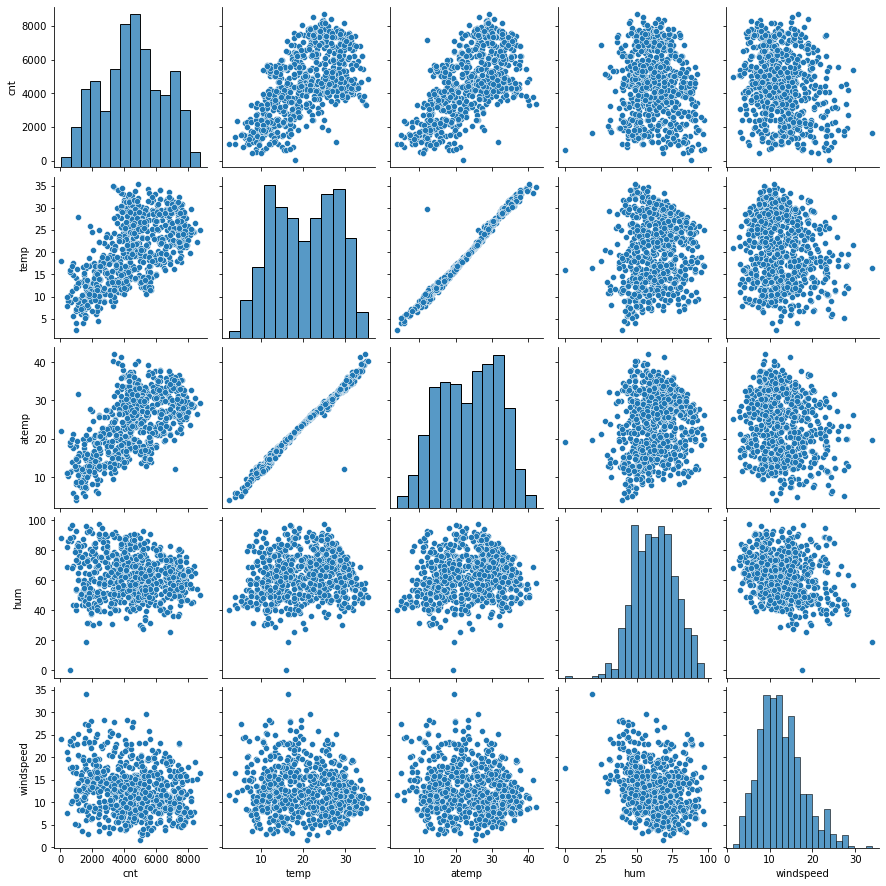

In [18]:
sns.pairplot(bike[numerical])
plt.show()


Insights

    The above Pair-Plot tells us that there is a LINEAR RELATION between 'temp','atemp' and 'cnt'



In [19]:
#correlation: 
corr=bike[numerical].corr()
corr

,cnt,temp,atemp,hum,windspeed
cnt,1.000000,0.627044,0.630685,-0.098543,-0.235132
temp,0.627044,1.000000,0.991696,0.128565,-0.158186
atemp,0.630685,0.991696,1.000000,0.141512,-0.183876
hum,-0.098543,0.128565,0.141512,1.000000,-0.248506
windspeed,-0.235132,-0.158186,-0.183876,-0.248506,1.000000


<AxesSubplot:>

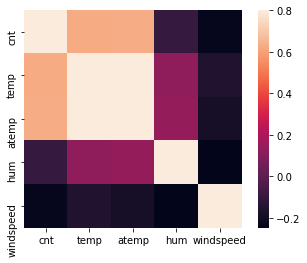

In [20]:
sns.heatmap(corr,vmax=.8, square=True)

In [21]:
mask = np.array(corr)
mask

array([[ 1.        ,  0.62704403,  0.63068535, -0.09854288, -0.2351325 ],
       [ 0.62704403,  1.        ,  0.99169618,  0.12856468, -0.15818638],
       [ 0.63068535,  0.99169618,  1.        ,  0.14151172, -0.1838764 ],
       [-0.09854288,  0.12856468,  0.14151172,  1.        , -0.24850587],
       [-0.2351325 , -0.15818638, -0.1838764 , -0.24850587,  1.        ]])

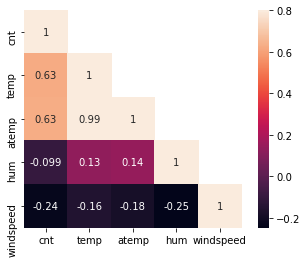

In [22]:
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr, mask=mask, vmax=.8, square=True, annot=True);

#Visualisation for categorical variables 


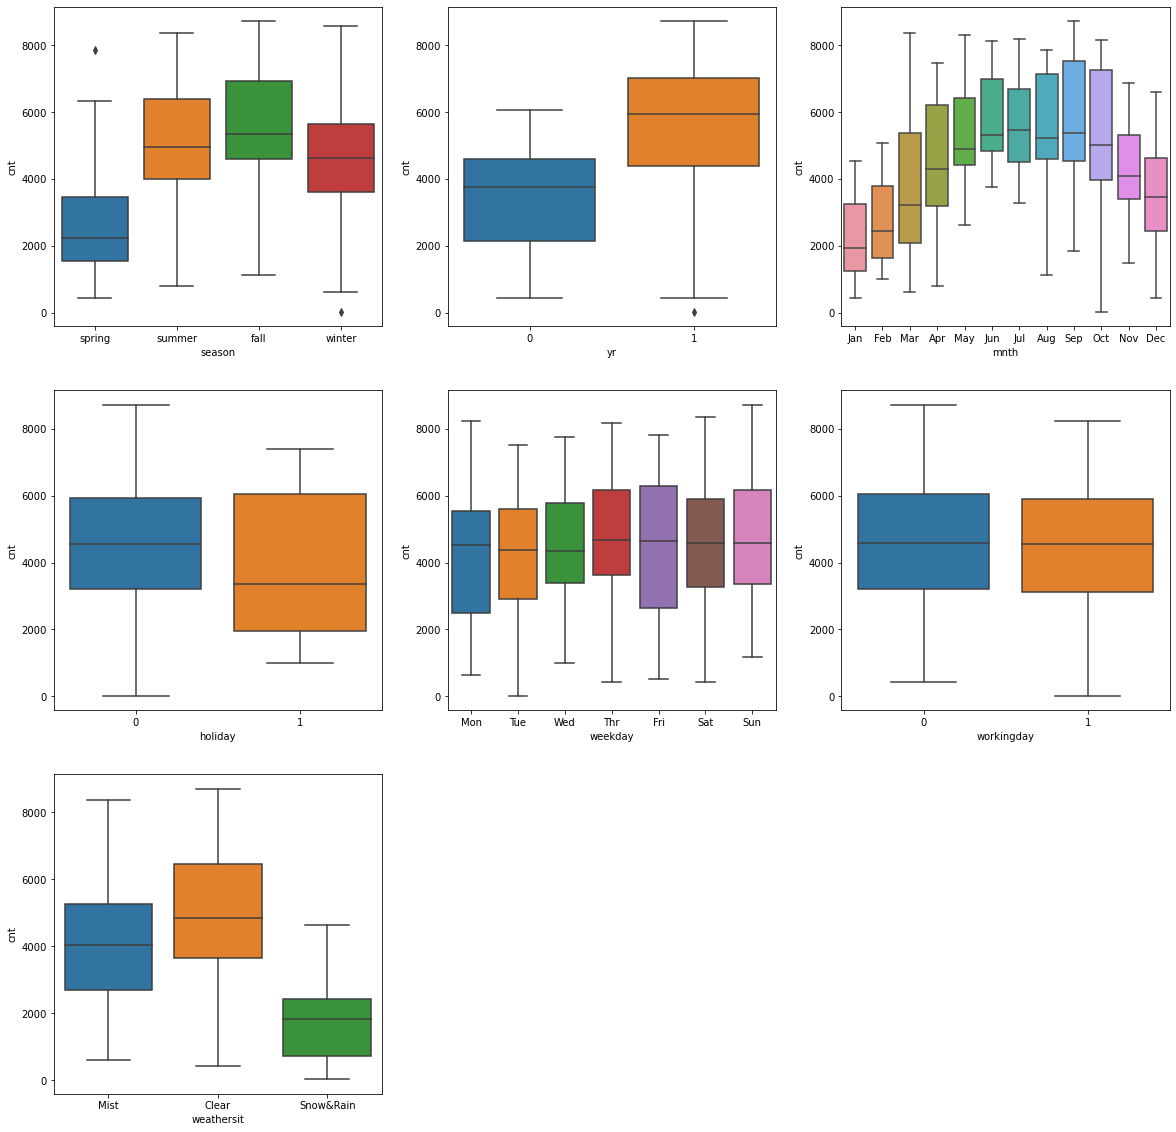

In [23]:
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.boxplot(x='season', y='cnt', data=bike)
plt.subplot(3,3,2)
sns.boxplot(x='yr', y='cnt', data=bike)
plt.subplot(3,3,3)
sns.boxplot(x='mnth', y='cnt', data=bike)
plt.subplot(3,3,4)
sns.boxplot(x='holiday', y='cnt', data=bike)
plt.subplot(3,3,5)
sns.boxplot(x='weekday', y='cnt', data=bike)
plt.subplot(3,3,6)
sns.boxplot(x='workingday', y='cnt', data=bike)
plt.subplot(3,3,7)
sns.boxplot(x='weathersit', y='cnt', data=bike)
plt.show();

Question 1. From your analysis of the categorical variables from the dataset, what could you infer about 
their effect on the dependent variable? 


Inference:
There are 7 categorical variables in the dataset
    1. The demad of bike is less in the month of spring when compared with other seasons
    2. The demand bike increased in the year 2019 when compared with year 2018.
    3. Month Jun to Sep is the period when bike demand is high. The Month Jan is the lowest demand month.
    4. Bike demand is less in holidays in comparison to not being holiday.
    5. The demand of bike is almost similar throughout the weekdays.
    6. There is no significant change in bike demand with workign day and non working day.
    7. The bike demand is high when weather is clear and Few clouds however demand is less in case of Lightsnow and    light rainfall. We do not have any dat for Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog , so we can not derive any conclusion. 

#Data preparation

- getting dummy variables 
-split into train and test 
- rescaling variables


In [24]:
categorical=['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday','weathersit']

In [25]:
bike[categorical].columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit'],
      dtype='object')

In [26]:
df_dummies=pd.get_dummies(bike[categorical], drop_first=True)
df_dummies.head()

,yr,holiday,workingday,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,weathersit_Mist,weathersit_Snow&Rain
0,0,0,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
2,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Insights:
     drop_first=True is important to use, as it helps in reducing the extra column created during dummy variable creation. Hence it reduces the correlations created among dummy variables

In [27]:
bike = bike.drop(list(bike[categorical].columns), axis=1)


In [28]:
bike = pd.concat([bike, df_dummies], axis=1)

In [29]:
bike

,temp,atemp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,weathersit_Mist,weathersit_Snow&Rain
0,14.110847,18.18125,80.5833,10.749882,985,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
1,14.902598,17.68695,69.6087,16.652113,801,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
2,8.050924,9.47025,43.7273,16.636703,1349,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,8.200000,10.60610,59.0435,10.739832,1562,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
4,9.305237,11.46350,43.6957,12.522300,1600,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,10.420847,11.33210,65.2917,23.458911,2114,1,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
726,10.386653,12.75230,59.0000,10.416557,3095,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
727,10.386653,12.12000,75.2917,8.333661,1341,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
728,10.489153,11.58500,48.3333,23.500518,1796,1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0


In [30]:
bike.shape

(730, 30)

In [31]:
# splitting the data into train and test using sklearn

In [32]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(bike, train_size = 0.7, test_size = 0.3, random_state = 0)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(219, 30)


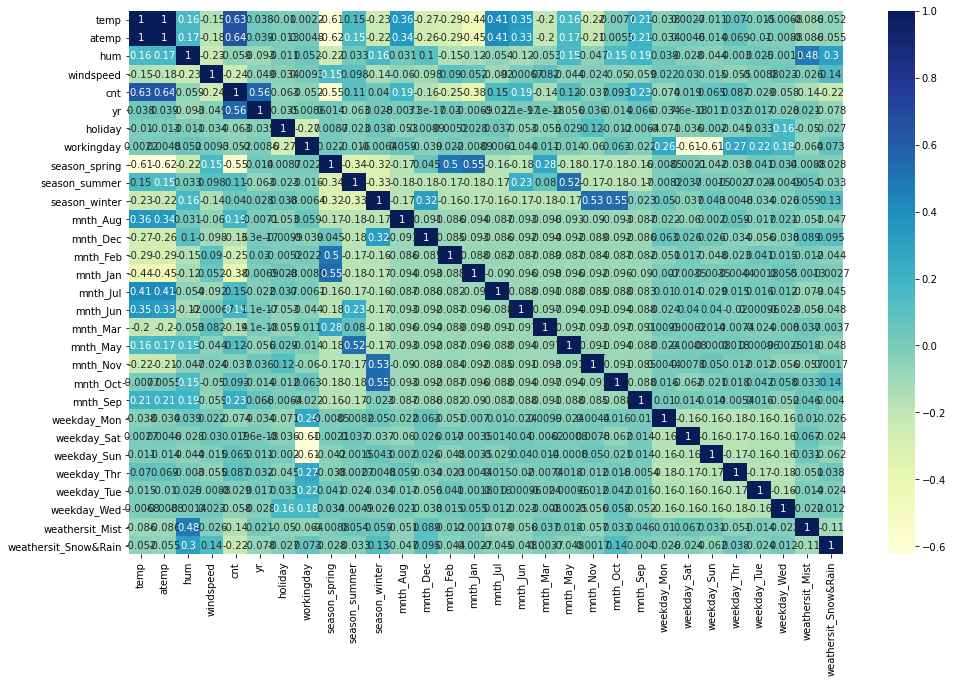

In [33]:
# Let's check the correlation coefficients to see which variables are highly correlated

plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()


Insights:

    The heatmap clearly shows which all variable are multicollinear in nature, and which variable have high collinearity with the target variable.

In [34]:
bike

,temp,atemp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,weathersit_Mist,weathersit_Snow&Rain
0,14.110847,18.18125,80.5833,10.749882,985,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
1,14.902598,17.68695,69.6087,16.652113,801,0,0,1,1,0,...,0,0,0,0,0,0,1,0,1,0
2,8.050924,9.47025,43.7273,16.636703,1349,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
3,8.200000,10.60610,59.0435,10.739832,1562,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
4,9.305237,11.46350,43.6957,12.522300,1600,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,10.420847,11.33210,65.2917,23.458911,2114,1,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
726,10.386653,12.75230,59.0000,10.416557,3095,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
727,10.386653,12.12000,75.2917,8.333661,1341,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
728,10.489153,11.58500,48.3333,23.500518,1796,1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0


In [35]:

#RESCALING THE FEATURES


In [36]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
# Instantiate an object
scaler =MinMaxScaler()
# create a list of numeric vars
num_vars= ['cnt','atemp','hum','windspeed','temp']
# fit on data 
df_train[num_vars]=scaler.fit_transform(df_train[num_vars])
df_train.head()

,temp,atemp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,weathersit_Mist,weathersit_Snow&Rain
235,0.753859,0.731037,0.488399,0.527988,0.587667,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
524,0.802869,0.755332,0.254640,0.255430,0.860101,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
12,0.089497,0.071535,0.301044,0.647940,0.159227,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
161,0.821384,0.796115,0.557424,0.281887,0.568799,0,0,1,0,1,...,0,0,1,0,0,0,0,0,0,0
556,0.810494,0.757949,0.527842,0.274080,0.833180,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [38]:
### Dividing into X and Y sets for the model building

y_train = df_train.pop('cnt')
X_train = df_train

Building a Linear Model

In [39]:
#RFE: Recurrsive feature elimination from sklearn
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


In [40]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 15)          
rfe = rfe.fit(X_train, y_train)

In [41]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('season_spring', True, 1),
 ('season_summer', False, 14),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 12),
 ('mnth_Dec', True, 1),
 ('mnth_Feb', True, 1),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 10),
 ('mnth_Mar', False, 15),
 ('mnth_May', False, 2),
 ('mnth_Nov', True, 1),
 ('mnth_Oct', False, 11),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', False, 7),
 ('weekday_Sat', False, 5),
 ('weekday_Sun', False, 6),
 ('weekday_Thr', False, 13),
 ('weekday_Tue', False, 8),
 ('weekday_Wed', False, 9),
 ('weathersit_Mist', False, 3),
 ('weathersit_Snow&Rain', True, 1)]

In [42]:
column = X_train.columns[rfe.support_]
column

Index(['temp', 'atemp', 'hum', 'windspeed', 'yr', 'holiday', 'season_spring',
       'season_winter', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul',
       'mnth_Nov', 'mnth_Sep', 'weathersit_Snow&Rain'],
      dtype='object')

In [43]:
X_train.columns[~rfe.support_]

Index(['workingday', 'season_summer', 'mnth_Aug', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Oct', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thr', 'weekday_Tue', 'weekday_Wed', 'weathersit_Mist'],
      dtype='object')

In [44]:
X_train_rfe = X_train[column]

In [45]:
X_train_rfe

,temp,atemp,hum,windspeed,yr,holiday,season_spring,season_winter,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Nov,mnth_Sep,weathersit_Snow&Rain
235,0.753859,0.731037,0.488399,0.527988,0,0,0,0,0,0,0,0,0,0,0
524,0.802869,0.755332,0.254640,0.255430,1,0,0,0,0,0,0,0,0,0,0
12,0.089497,0.071535,0.301044,0.647940,0,0,1,0,0,0,1,0,0,0,0
161,0.821384,0.796115,0.557424,0.281887,0,0,0,0,0,0,0,0,0,0,0
556,0.810494,0.757949,0.527842,0.274080,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.294346,0.297851,0.351912,0.493817,0,1,1,0,1,0,0,0,0,0,0
707,0.375936,0.400404,0.906613,0.289714,1,0,0,1,1,0,0,0,0,0,0
192,0.911781,0.880286,0.424594,0.395608,0,0,0,0,0,0,0,1,0,0,0
629,0.723364,0.703267,0.546404,0.604317,1,0,0,0,0,0,0,0,0,1,0


Building a model with stats model:

In [46]:
import statsmodels.api as sm


In [47]:
# build a model with all variables
X_train_sm=sm.add_constant(X_train_rfe)

#createmodel
lr=sm.OLS(y_train, X_train_sm)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     153.0
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          1.30e-174
Time:                        20:05:20   Log-Likelihood:                 497.26
No. Observations:                 510   AIC:                            -962.5
Df Residuals:                     494   BIC:                            -894.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3581      0.029     12.235      0.000       0.301       0.416
temp                    -0.2224      0.229     -0.971      0.332      -0.672       0.227
atemp                    0.6880      0.245      2.804      0.005       0.206       1.170
hum                     -0.2116      0.025     -8.594      0.000      -0.260      -0.163
windspeed               -0.1334      0.024     -5.531      0.000      -0.181      -0.086
yr                       0.2191      0.008     26.136      0.000       0.203       0.236
holiday                 -0.0460      0.025     -1.869      0.062      -0.094       0.002
season_spring           -0.0903      0.019     -4.857      0.000      -0.127      -0.054
season_winter            0.0632      0.015      4.329      0.000       0.034       0.092
mnth_Dec                -0.0571      0.019     -3.049      0.002      -0.094      -0.020
mnth_Feb                -0.0532      0.022     -2.439      0.015      -0.096      -0.010
mnth_Jan                -0.0620      0.022     -2.837      0.005      -0.105      -0.019
mnth_Jul                -0.0704      0.018     -3.971      0.000      -0.105      -0.036
mnth_Nov                -0.0632      0.020     -3.154      0.002      -0.103      -0.024
mnth_Sep                 0.0605      0.016      3.683      0.000       0.028       0.093
weathersit_Snow&Rain    -0.1471      0.030     -4.980      0.000      -0.205      -0.089
==============================================================================
Omnibus:                       83.577   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              196.829
Skew:                          -0.853   Prob(JB):                     1.82e-43
Kurtosis:                       5.521   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
#VIF

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [50]:
vif = pd.DataFrame()
vif['Features']=X_train_rfe.columns
vif['VIF'] =[variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] =round(vif['VIF'],2)
vif =vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,atemp,994.64
0,temp,953.12
2,hum,9.10
6,season_spring,4.26
3,windspeed,4.07
7,season_winter,2.81
10,mnth_Jan,2.31
4,yr,2.06
9,mnth_Feb,2.06
12,mnth_Nov,1.80


In [51]:
#Removing High P and High VIF  and building model 2

In [52]:
X=X_train_rfe.drop(["temp"],axis=1)

In [53]:
# build a model with all variables
X_train_sm=sm.add_constant(X)

#createmodel
lr=sm.OLS(y_train, X_train_sm)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     163.9
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          1.60e-175
Time:                        20:05:20   Log-Likelihood:                 496.77
No. Observations:                 510   AIC:                            -963.5
Df Residuals:                     495   BIC:                            -900.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3647      0.028     12.812      0.000       0.309       0.421
atemp                    0.4519      0.034     13.303      0.000       0.385       0.519
hum                     -0.2088      0.024     -8.540      0.000      -0.257      -0.161
windspeed               -0.1394      0.023     -5.984      0.000      -0.185      -0.094
yr                       0.2191      0.008     26.136      0.000       0.203       0.236
holiday                 -0.0475      0.025     -1.930      0.054      -0.096       0.001
season_spring           -0.0896      0.019     -4.824      0.000      -0.126      -0.053
season_winter            0.0650      0.014      4.490      0.000       0.037       0.093
mnth_Dec                -0.0568      0.019     -3.034      0.003      -0.094      -0.020
mnth_Feb                -0.0530      0.022     -2.433      0.015      -0.096      -0.010
mnth_Jan                -0.0632      0.022     -2.894      0.004      -0.106      -0.020
mnth_Jul                -0.0714      0.018     -4.029      0.000      -0.106      -0.037
mnth_Nov                -0.0631      0.020     -3.146      0.002      -0.102      -0.024
mnth_Sep                 0.0589      0.016      3.604      0.000       0.027       0.091
weathersit_Snow&Rain    -0.1489      0.029     -5.050      0.000      -0.207      -0.091
==============================================================================
Omnibus:                       82.225   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.779
Skew:                          -0.841   Prob(JB):                     1.38e-42
Kurtosis:                       5.498   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
vif = pd.DataFrame()
vif['Features']=X.columns
vif['VIF'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] =round(vif['VIF'],2)
vif =vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,atemp,9.57
1,hum,8.59
5,season_spring,4.17
2,windspeed,3.98
6,season_winter,2.69
9,mnth_Jan,2.31
3,yr,2.06
8,mnth_Feb,2.05
11,mnth_Nov,1.80
7,mnth_Dec,1.60


In [55]:
# removing high P and building model 3

In [56]:
X=X.drop(["holiday"], axis=1)

In [57]:
# build a model with all variables
X_train_sm=sm.add_constant(X)

#createmodel
lr=sm.OLS(y_train, X_train_sm)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     175.2
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          7.48e-176
Time:                        20:05:20   Log-Likelihood:                 494.86
No. Observations:                 510   AIC:                            -961.7
Df Residuals:                     496   BIC:                            -902.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3645      0.029     12.772      0.000       0.308       0.421
atemp                    0.4496      0.034     13.209      0.000       0.383       0.517
hum                     -0.2088      0.025     -8.514      0.000      -0.257      -0.161
windspeed               -0.1384      0.023     -5.927      0.000      -0.184      -0.093
yr                       0.2199      0.008     26.181      0.000       0.203       0.236
season_spring           -0.0904      0.019     -4.855      0.000      -0.127      -0.054
season_winter            0.0652      0.015      4.489      0.000       0.037       0.094
mnth_Dec                -0.0577      0.019     -3.077      0.002      -0.095      -0.021
mnth_Feb                -0.0536      0.022     -2.451      0.015      -0.097      -0.011
mnth_Jan                -0.0648      0.022     -2.960      0.003      -0.108      -0.022
mnth_Jul                -0.0725      0.018     -4.083      0.000      -0.107      -0.038
mnth_Nov                -0.0678      0.020     -3.397      0.001      -0.107      -0.029
mnth_Sep                 0.0585      0.016      3.567      0.000       0.026       0.091
weathersit_Snow&Rain    -0.1477      0.030     -4.997      0.000      -0.206      -0.090
==============================================================================
Omnibus:                       86.919   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.627
Skew:                          -0.880   Prob(JB):                     8.21e-46
Kurtosis:                       5.584   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
vif = pd.DataFrame()
vif['Features']=X.columns
vif['VIF'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] =round(vif['VIF'],2)
vif =vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,atemp,9.54
1,hum,8.59
4,season_spring,4.17
2,windspeed,3.97
5,season_winter,2.69
8,mnth_Jan,2.31
3,yr,2.05
7,mnth_Feb,2.05
10,mnth_Nov,1.77
6,mnth_Dec,1.60


In [59]:
# removing high p  and building model 4.

In [60]:
X=X.drop(["mnth_Feb"], axis=1)

In [61]:
# build a model with all variables
X_train_sm=sm.add_constant(X)

#createmodel
lr=sm.OLS(y_train, X_train_sm)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     187.4
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          1.04e-175
Time:                        20:05:20   Log-Likelihood:                 491.79
No. Observations:                 510   AIC:                            -957.6
Df Residuals:                     497   BIC:                            -902.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3542      0.028     12.484      0.000       0.298       0.410
atemp                    0.4631      0.034     13.718      0.000       0.397       0.529
hum                     -0.2072      0.025     -8.410      0.000      -0.256      -0.159
windspeed               -0.1353      0.023     -5.773      0.000      -0.181      -0.089
yr                       0.2192      0.008     25.985      0.000       0.203       0.236
season_spring           -0.1135      0.016     -7.029      0.000      -0.145      -0.082
season_winter            0.0629      0.015      4.321      0.000       0.034       0.092
mnth_Dec                -0.0444      0.018     -2.462      0.014      -0.080      -0.009
mnth_Jan                -0.0354      0.018     -1.924      0.055      -0.072       0.001
mnth_Jul                -0.0748      0.018     -4.199      0.000      -0.110      -0.040
mnth_Nov                -0.0613      0.020     -3.086      0.002      -0.100      -0.022
mnth_Sep                 0.0585      0.016      3.553      0.000       0.026       0.091
weathersit_Snow&Rain    -0.1472      0.030     -4.956      0.000      -0.206      -0.089
==============================================================================
Omnibus:                       77.791   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.728
Skew:                          -0.796   Prob(JB):                     1.27e-40
Kurtosis:                       5.472   Cond. No.                         15.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
vif = pd.DataFrame()
vif['Features']=X.columns
vif['VIF'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] =round(vif['VIF'],2)
vif =vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,atemp,9.48
1,hum,8.57
2,windspeed,3.97
5,season_winter,2.66
4,season_spring,2.52
3,yr,2.05
9,mnth_Nov,1.75
7,mnth_Jan,1.65
6,mnth_Dec,1.49
8,mnth_Jul,1.40


In [63]:
# removing high p  and building model 5.

In [64]:
X=X.drop(["mnth_Jan"], axis=1)

In [65]:
# build a model with all variables
X_train_sm=sm.add_constant(X)

#createmodel
lr=sm.OLS(y_train, X_train_sm)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     203.0
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          4.49e-176
Time:                        20:05:20   Log-Likelihood:                 489.90
No. Observations:                 510   AIC:                            -955.8
Df Residuals:                     498   BIC:                            -905.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3417      0.028     12.339      0.000       0.287       0.396
atemp                    0.4813      0.033     14.804      0.000       0.417       0.545
hum                     -0.2084      0.025     -8.436      0.000      -0.257      -0.160
windspeed               -0.1309      0.023     -5.598      0.000      -0.177      -0.085
yr                       0.2190      0.008     25.892      0.000       0.202       0.236
season_spring           -0.1205      0.016     -7.645      0.000      -0.151      -0.090
season_winter            0.0638      0.015      4.372      0.000       0.035       0.092
mnth_Dec                -0.0365      0.018     -2.074      0.039      -0.071      -0.002
mnth_Jul                -0.0782      0.018     -4.398      0.000      -0.113      -0.043
mnth_Nov                -0.0569      0.020     -2.873      0.004      -0.096      -0.018
mnth_Sep                 0.0580      0.017      3.514      0.000       0.026       0.091
weathersit_Snow&Rain    -0.1484      0.030     -4.984      0.000      -0.207      -0.090
==============================================================================
Omnibus:                       74.473   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              173.082
Skew:                          -0.770   Prob(JB):                     2.60e-38
Kurtosis:                       5.403   Cond. No.                         15.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
vif = pd.DataFrame()
vif['Features']=X.columns
vif['VIF'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] =round(vif['VIF'],2)
vif =vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,atemp,9.22
1,hum,8.39
2,windspeed,3.96
5,season_winter,2.65
3,yr,2.04
4,season_spring,2.02
8,mnth_Nov,1.74
6,mnth_Dec,1.44
7,mnth_Jul,1.39
9,mnth_Sep,1.20


In [67]:
# removing high p  and building model 6.

In [68]:
X=X.drop(["mnth_Dec"], axis=1)

In [69]:
# build a model with all variables
X_train_sm=sm.add_constant(X)

#createmodel
lr=sm.OLS(y_train, X_train_sm)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     221.4
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          2.48e-176
Time:                        20:05:20   Log-Likelihood:                 487.71
No. Observations:                 510   AIC:                            -953.4
Df Residuals:                     499   BIC:                            -906.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3314      0.027     12.124      0.000       0.278       0.385
atemp                    0.4966      0.032     15.631      0.000       0.434       0.559
hum                     -0.2109      0.025     -8.520      0.000      -0.259      -0.162
windspeed               -0.1263      0.023     -5.406      0.000      -0.172      -0.080
yr                       0.2185      0.008     25.758      0.000       0.202       0.235
season_spring           -0.1186      0.016     -7.512      0.000      -0.150      -0.088
season_winter            0.0542      0.014      3.904      0.000       0.027       0.081
mnth_Jul                -0.0807      0.018     -4.534      0.000      -0.116      -0.046
mnth_Nov                -0.0424      0.019     -2.282      0.023      -0.079      -0.006
mnth_Sep                 0.0604      0.017      3.654      0.000       0.028       0.093
weathersit_Snow&Rain    -0.1501      0.030     -5.025      0.000      -0.209      -0.091
==============================================================================
Omnibus:                       69.193   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.073
Skew:                          -0.738   Prob(JB):                     9.50e-34
Kurtosis:                       5.231   Cond. No.                         15.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
vif = pd.DataFrame()
vif['Features']=X.columns
vif['VIF'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] =round(vif['VIF'],2)
vif =vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,atemp,9.03
1,hum,8.20
2,windspeed,3.96
5,season_winter,2.22
3,yr,2.04
4,season_spring,2.01
7,mnth_Nov,1.56
6,mnth_Jul,1.39
8,mnth_Sep,1.20
9,weathersit_Snow&Rain,1.17


In [71]:
#dropping high p and building model 7

In [72]:
X=X.drop(["mnth_Nov"], axis=1)

In [73]:
# build a model with all variables
X_train_sm=sm.add_constant(X)

#createmodel
lr=sm.OLS(y_train, X_train_sm)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     243.4
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          2.04e-176
Time:                        20:05:21   Log-Likelihood:                 485.06
No. Observations:                 510   AIC:                            -950.1
Df Residuals:                     500   BIC:                            -907.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3209      0.027     11.860      0.000       0.268       0.374
atemp                    0.5086      0.031     16.170      0.000       0.447       0.570
hum                     -0.2052      0.025     -8.298      0.000      -0.254      -0.157
windspeed               -0.1270      0.023     -5.414      0.000      -0.173      -0.081
yr                       0.2178      0.009     25.589      0.000       0.201       0.235
season_spring           -0.1132      0.016     -7.222      0.000      -0.144      -0.082
season_winter            0.0423      0.013      3.275      0.001       0.017       0.068
mnth_Jul                -0.0825      0.018     -4.623      0.000      -0.118      -0.047
mnth_Sep                 0.0620      0.017      3.740      0.000       0.029       0.095
weathersit_Snow&Rain    -0.1470      0.030     -4.907      0.000      -0.206      -0.088
==============================================================================
Omnibus:                       70.880   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              157.663
Skew:                          -0.750   Prob(JB):                     5.81e-35
Kurtosis:                       5.273   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
vif = pd.DataFrame()
vif['Features']=X.columns
vif['VIF'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] =round(vif['VIF'],2)
vif =vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,atemp,8.98
1,hum,8.19
2,windspeed,3.90
3,yr,2.03
4,season_spring,2.00
5,season_winter,1.69
6,mnth_Jul,1.38
7,mnth_Sep,1.19
8,weathersit_Snow&Rain,1.17


In [75]:
#Dropping second high vif, as first high vif 'atemp ' looks important variable in bike dataset

In [76]:
X=X.drop(["hum"], axis=1)

In [77]:
# build a model with all variables
X_train_sm=sm.add_constant(X)

#createmodel
lr=sm.OLS(y_train, X_train_sm)

#fit
lr_model = lr.fit()

#params
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     233.6
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          1.18e-163
Time:                        20:05:21   Log-Likelihood:                 452.16
No. Observations:                 510   AIC:                            -886.3
Df Residuals:                     501   BIC:                            -848.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2142      0.025      8.444      0.000       0.164       0.264
atemp                    0.4767      0.033     14.331      0.000       0.411       0.542
windspeed               -0.0804      0.024     -3.312      0.001      -0.128      -0.033
yr                       0.2259      0.009     25.065      0.000       0.208       0.244
season_spring           -0.1106      0.017     -6.625      0.000      -0.143      -0.078
season_winter            0.0319      0.014      2.328      0.020       0.005       0.059
mnth_Jul                -0.0656      0.019     -3.470      0.001      -0.103      -0.028
mnth_Sep                 0.0421      0.017      2.408      0.016       0.008       0.076
weathersit_Snow&Rain    -0.2301      0.030     -7.651      0.000      -0.289      -0.171
==============================================================================
Omnibus:                       70.279   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.081
Skew:                          -0.805   Prob(JB):                     2.08e-29
Kurtosis:                       4.903   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
vif = pd.DataFrame()
vif['Features']=X.columns
vif['VIF'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] =round(vif['VIF'],2)
vif =vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
0,atemp,4.24
1,windspeed,3.90
2,yr,2.03
3,season_spring,1.63
4,season_winter,1.34
5,mnth_Jul,1.34
6,mnth_Sep,1.18
7,weathersit_Snow&Rain,1.07


In [79]:
# Inference: Model 6 looks good, as multicollinearity is low between the variables p values of all the variables is significant. VIF is below 5 adjusted R squared: is 0.785 which looks good


The equation of best fitted surface based on model lr6:

cnt = 0.2142 + (atemp × 0.4767)+ (windspeed × 0.0804) + (yr × 0.2259) - (season_spring ×0.1106) + (season_winter × 0.0319) - (mnth_Jul ×0.0656) + (mnth_Sep × 0.0421) − (weathersit_Snow&Rain × 0.2301)


Interpretation:
    
    1. Const: The Constant value of ‘0.2142’ indicates that, The bike rental can still increase by 0.2142 units. Even if all the other predected variables are absent.
    2. atemp: A coefficient value of ‘0.4767’ indicated that a unit increase in atemp variable, increases the bike hire numbers by 0.4767 units 
    3. windspeed :A coefficient value of ‘-0.0804’ indicated that, a unit increase in windspeed variable decreases the bike hire numbers by 0.0804 units.
    4. yr:A coefficient value of ‘0.2259’ indicated that a unit increase in yr variable, increases the bike hire numbers by 0.2259 units     
    5. season_spring: A coefficient value of ‘-0.1106’ indicated that a unit increase in season_spring variable decreases the bike hire numbers by 0.1106 units
    6. season_winter: A coefficient value of ‘0.0319’ indicated that a unit increase in season_winter variable increases the bike hire numbers by 0.0319 units
    7. mnth_Jul : A coefficient value of ‘0.0656’ indicated that a unit increase in mnth_Jul variable decreases the bike hire numbers by 0.0656 units 
    8. mnth_Sep : A coefficient value of ‘0.0421’ indicated that a unit increase in mnth_Sep variable increases the bike hire numbers by 0.0421 units	
    9.weathersit_Snow&Rain	:A coefficient value of ‘-0.2301’ indicated that a unit increase in weathersit_Snow&Rain variable increases the bike hire numbers by -0.2301 units	

# Model Validation

Validating the assumption of Linear Regression Model :

    Linear Relationship
    Homoscedasticity
    Absence of Multicollinearity
    Independence of residuals
    Normality of Errors


In [ ]:
#Linear Relationship

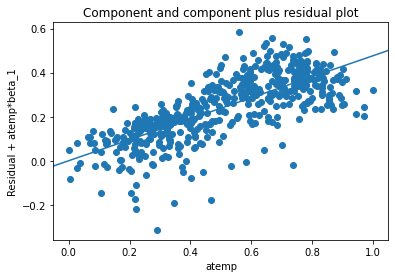

In [81]:
sm.graphics.plot_ccpr(lr_model, 'atemp')
plt.show()

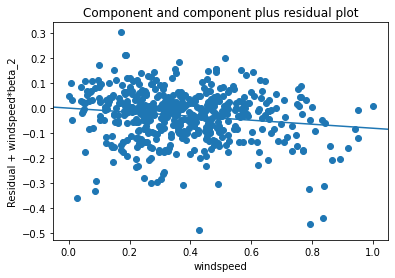

In [82]:
sm.graphics.plot_ccpr(lr_model, 'windspeed')
plt.show()

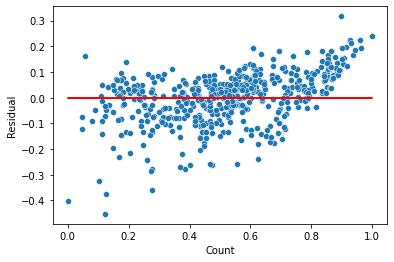

In [83]:
y_train_pred = lr_model.predict(X_train_sm)
residual = y_train - y_train_pred
sns.scatterplot(y_train,residual)
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()


 There is no visible pattern in residual values, thus homoscedacity is well preserved


Absence of Multicolinearity 

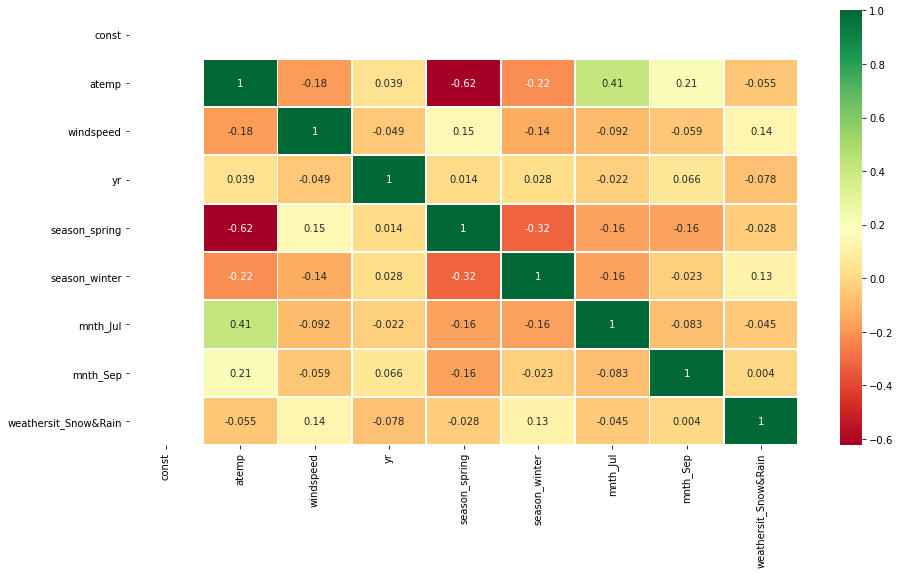

In [84]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train_sm.corr(),annot = True, cmap="RdYlGn",linewidth =1)
plt.show()

In [85]:
vif

,Features,VIF
0,atemp,4.24
1,windspeed,3.90
2,yr,2.03
3,season_spring,1.63
4,season_winter,1.34
5,mnth_Jul,1.34
6,mnth_Sep,1.18
7,weathersit_Snow&Rain,1.07


All the predictor variables have VIF value less than 5. So we can consider that there is insignificant multicolinearity among the predictor variables. 

In [ ]:
# Residual Analysis on trainin set

In [86]:
y_train_pred = lr_model.predict(X_train_sm)
y_train_pred

235    0.520318
524    0.779678
12     0.085622
161    0.571121
556    0.713849
         ...   
359    0.205902
707    0.639627
192    0.536532
629    0.768930
559    0.725804
Length: 510, dtype: float64

<AxesSubplot:ylabel='Density'>

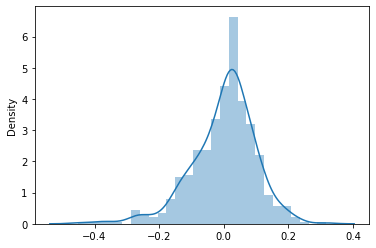

In [87]:
res=y_train - y_train_pred
sns.distplot(res)

From the distplot, we notice that the Residuals are normally distributed. Hence our assumption for Linear Regression is valid.

Independence of residuals

Autocorrelation refers to the fact that observations’ errors are correlated. To verify that the observations are not auto-correlated, we can use the Durbin-Watson test. The test will output values between 0 and 4. The closer it is to 2, the less auto-correlation there is between the various variables.

    0 – 2: positive auto-correlation
    2 – 4: negative auto-correlation) 



In [88]:
print('The Durbin-Watson value for Final Model lr 6 is',round(sm.stats.stattools.durbin_watson((y_train - y_train_pred)),4))

The Durbin-Watson value for Final Model lr 6 is 2.0292


 There is almost no autocorrelation. 

# Predictions and evaluation on the test set

In [89]:
# create a list of numeric vars
num_vars= ['cnt','atemp','hum','windspeed','temp']
# fit on data 
df_test[num_vars]=scaler.transform(df_test[num_vars])
df_test.head()

,temp,atemp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,weathersit_Mist,weathersit_Snow&Rain
196,0.771285,0.741444,0.460557,0.415865,0.678900,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
187,0.854058,0.808256,0.552784,0.292782,0.525771,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14,0.178804,0.205177,0.340487,0.289684,0.141049,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
31,0.125012,0.186509,0.801018,0.027323,0.153935,0,0,1,1,0,...,0,0,0,0,0,1,0,0,1,0
390,0.320391,0.353539,0.717517,0.077873,0.466291,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [90]:
df_test.describe()

,temp,atemp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thr,weekday_Tue,weekday_Wed,weathersit_Mist,weathersit_Snow&Rain
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.537535,0.530211,0.533186,0.365412,0.520493,0.497717,0.027397,0.666667,0.251142,0.237443,...,0.082192,0.095890,0.150685,0.150685,0.155251,0.100457,0.164384,0.150685,0.342466,0.041096
std,0.230350,0.215531,0.206381,0.198115,0.236180,0.501140,0.163612,0.472484,0.434663,0.426491,...,0.275286,0.295115,0.358561,0.358561,0.362974,0.301297,0.371472,0.358561,0.475622,0.198967
min,-0.048868,-0.027173,-0.353829,-0.049874,0.067073,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.359598,0.370098,0.386311,0.226618,0.354809,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.564352,0.567870,0.529582,0.327053,0.519673,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.722275,0.693736,0.678414,0.463343,0.723194,1.000000,0.000000,1.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.982573,1.019965,0.986079,1.165056,0.981707,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
y_test = df_test.pop('cnt')
X_test = df_test

In [92]:
X_train_sm.columns # we need columns present in x train for 

Index(['const', 'atemp', 'windspeed', 'yr', 'season_spring', 'season_winter',
       'mnth_Jul', 'mnth_Sep', 'weathersit_Snow&Rain'],
      dtype='object')

In [93]:
# Creating X_test_sm dataframe by dropping variables from X_test
X_test_sm= X_test[(X_train_sm.drop('const',axis=1)).columns]

In [94]:
X_test_sm.shape

(219, 8)

In [95]:
# add a constant
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm.head()

,const,atemp,windspeed,yr,season_spring,season_winter,mnth_Jul,mnth_Sep,weathersit_Snow&Rain
196,1.0,0.741444,0.415865,0,0,0,1,0,0
187,1.0,0.808256,0.292782,0,0,0,1,0,0
14,1.0,0.205177,0.289684,0,1,0,0,0,0
31,1.0,0.186509,0.027323,0,1,0,0,0,0
390,1.0,0.353539,0.077873,1,1,0,0,0,0


In [96]:
X_test_sm.shape

(219, 9)

In [ ]:
# predictions

In [99]:
y_test_pred =lr_model.predict(X_test_sm)

In [100]:
y_test_pred

196    0.468712
187    0.510456
14     0.178126
31     0.190311
390    0.491752
         ...   
155    0.534248
391    0.476432
571    0.745377
306    0.428350
200    0.558894
Length: 219, dtype: float64

In [102]:
# Evaluate of test by comparing  y_pred and y_test
# R-squared score on the test set
from sklearn.metrics import r2_score

In [103]:
r_squared= r2_score(y_true=y_test,y_pred=y_test_pred)

In [104]:
n = X_test.shape[0]
p = X_test.shape[1]

In [105]:
adjusted_r2 = round(1-(1-r_squared)*(n-1)/(n-p-1),4)
adjusted_r2 

0.7766

In [106]:
from sklearn.metrics import mean_squared_error, r2_score 
mse = mean_squared_error(y_test, y_test_pred)

In [107]:
print('Mean_Squared_Error :' ,mse) 
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.010753575710085967
r_square_value : 0.8063337911466215


In [108]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     233.6
Date:                Wed, 08 Sep 2021   Prob (F-statistic):          1.18e-163
Time:                        20:14:14   Log-Likelihood:                 452.16
No. Observations:                 510   AIC:                            -886.3
Df Residuals:                     501   BIC:                            -848.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2142      0.025      8.444      0.000       0.164       0.264
atemp                    0.4767      0.033     14.331      0.000       0.411       0.542
windspeed               -0.0804      0.024     -3.312      0.001      -0.128      -0.033
yr                       0.2259      0.009     25.065      0.000       0.208       0.244
season_spring           -0.1106      0.017     -6.625      0.000      -0.143      -0.078
season_winter            0.0319      0.014      2.328      0.020       0.005       0.059
mnth_Jul                -0.0656      0.019     -3.470      0.001      -0.103      -0.028
mnth_Sep                 0.0421      0.017      2.408      0.016       0.008       0.076
weathersit_Snow&Rain    -0.2301      0.030     -7.651      0.000      -0.289      -0.171
==============================================================================
Omnibus:                       70.279   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.081
Skew:                          -0.805   Prob(JB):                     2.08e-29
Kurtosis:                       4.903   Cond. No.                         13.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
lr_model.params.sort_values(ascending=False)

atemp                   0.476743
yr                      0.225873
const                   0.214233
mnth_Sep                0.042113
season_winter           0.031914
mnth_Jul               -0.065578
windspeed              -0.080365
season_spring          -0.110643
weathersit_Snow&Rain   -0.230146
dtype: float64

# Final Model




y= 0.2142+(0.4767 X['atemp']) +(0.2258 X['yr']) + (0.0421 X['mnth_Sep'])+(0.0319 X["season_winter"])-(0.0655 X["mnth_Jul"])-(0.0803 X["windspeed"])-(0.1106 X["season_spring"])-(0.2301 X["weathersit_Snow&Rain"])


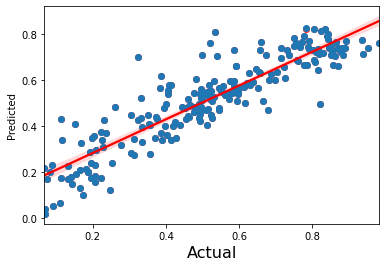

In [110]:
# Plotting y_test and y_test_pred to understand the spread.
fig = plt.figure()
res=y= 0.2142+(0.4767 * X_test_sm['atemp']) +(0.2258 *X_test_sm['yr']) + (0.0421* X_test_sm['mnth_Sep'])+(0.0319* X_test_sm["season_winter"])-(0.0655* X_test_sm["mnth_Jul"])-(0.0803 *X_test_sm["windspeed"])-(0.1106 *X_test_sm["season_spring"])-(0.2301* X_test_sm["weathersit_Snow&Rain"])
sns.regplot(x=y_test,y=res, color='r')
plt.scatter(y_test,y_test_pred)
plt.xlabel('Actual', fontsize=16)                          
plt.ylabel('Predicted', fontsize=10)     
plt.show()



we can observe that the predicted and actual values has strong correlation.

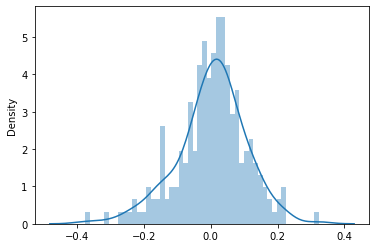

In [111]:
sns.distplot(y_test-y_test_pred,bins=50)
plt.show()

In [ ]:
print(lr_model.summary())

Final model includes the following variables: 
    1.atemp                    
    2.windspeed               
    3.yr                       
    4.season_spring           
    5.season_winter            
    6.mnth_Jul                
    7.mnth_Sep                 
    8.weathersit_Snow&Rain
    
 -> seasons are selected in a way that they do not overlap:
 -> july was selected and summer was removed and september was selected and fall was removed
 -> winter selected and nov,dec,jan was removed

# conclusion:


In [112]:
print('R- Sqaured train: ', round(lr_model.rsquared,2),'  Adj. R-Squared train:', round(lr_model.rsquared_adj,3) )
print('R- Sqaured train: ', round(r_squared,2),'  Adj. R-Squared train:', round(adjusted_r2,2))

R- Sqaured train:  0.79   Adj. R-Squared train: 0.785
R- Sqaured train:  0.81   Adj. R-Squared train: 0.78


From R-Sqaured and adj R-Sqaured value of both train and test dataset we could conclude that the above variables can well explained around 80% of bike demand


As per our final Model, the top 3 predictor variables that influences the bike booking are:

1. atemp: A coefficient value of ‘0.4767’ indicated that a unit increase in atemp variable, increases the bike hire numbers by 0.4767 units 
2. yr:A coefficient value of ‘0.2259’ indicated that a unit increase in yr variable, increases the bike hire numbers by 0.2259 units     
3.weathersit_Snow&Rain    :A coefficient value of ‘-0.2301’ indicated that a unit increase in weathersit_Snow&Rain variable increases the bike hire numbers by -0.2301 units 